In [21]:
import numpy as np
import pandas as pd

from scipy import stats, optimize

import matplotlib.pyplot as plt
from plotnine import *
import seaborn as sns

from matplotlib.lines import Line2D
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300

import importlib.util
import os

import warnings
warnings.filterwarnings('ignore')

#os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
#os.environ["CUDA_VISIBLE_DEVICES"]="1"


In [2]:
## datasets
folder = '../data/'

# Data
fn1 = 'scerevisiae_tpm_full_cut5.csv'
fn2 = 'scerevisiae_accessions.tsv'
fn3 = 'scerevisiae.rsd3.lmbda_22.npz'
fn4 = 'scerevisiae.rsd3.npz' # gene names, y use own

# use same seed for all runs for comparability
seed = 3131


In [3]:
# load data
def load_data(fname):
    # X is multi-variable array
    # Y contains single variable - fix shape for Keras

    npzfile = np.load(fname)
    Xh_train = npzfile['arr_0']
    Xh_test = npzfile['arr_1']
    Xv_train = npzfile['arr_2']
    Xv_test = npzfile['arr_3']
    Y_train = npzfile['arr_4']
    Y_test = npzfile['arr_5']
    g_train = npzfile['arr_6']
    g_test = npzfile['arr_7']

    X_train = list()
    #X_train.append(Xh_train)
    X_train.append(Xv_train[:,8:]/
                   (np.sum(Xv_train[:,8:],axis=1).reshape((-1,1)))) # [8: are codon frequencies]
    X_test = list()
    #X_test.append(Xh_test)
    X_test.append(Xv_test[:,8:]/
                   (np.sum(Xv_test[:,8:],axis=1).reshape((-1,1))))
    
    # transform

    Y_train = Y_train.astype(np.float32).reshape((-1,1))
    Y_test = Y_test.astype(np.float32).reshape((-1,1))

    return X_train, X_test, Y_train, Y_test, g_train, g_test

X_train, X_test, Y_train, Y_test, g_train, g_test = load_data(folder+fn4)

#X_train[0].shape[0]+X_test[0].shape[0]
gene_names = np.concatenate((g_train,g_test))
X = np.concatenate((X_train[0],X_test[0]))
print(gene_names.shape)
print(X.shape)


(4917,)
(4917, 64)


0.11302594196818178


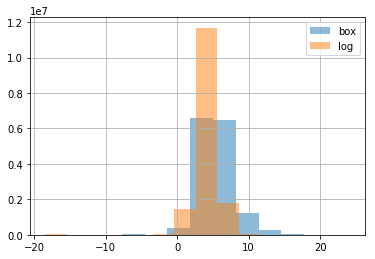

(14873925, 6)
(4917,)


,gene_id,sample_id,gene_len,TPM,box,log
0,YAL005C,SRR7242111,2313.0,973.837378,10.409905,6.881244
1,YAL005C,SRR7426367,2313.0,339.383558,8.246941,5.827131
2,YAL005C,SRR7242216,2313.0,232.165401,7.528871,5.447450
3,YAL005C,SRR3140106,2313.0,659.379465,9.579587,6.491299
4,YAL005C,SRR5448426,2313.0,337.381832,8.235515,5.821215


In [4]:
# load data
# rsd < 1 filtered data so we can use 

def get_rsd(x):
    return x.std()/x.mean()

def boxcox_transform(x, lmbda):
    return stats.boxcox(x,lmbda)

df = pd.read_csv(folder+fn1)

# rsd = df.groupby('gene_id').TPM.apply(get_rsd)
# rsd = rsd.reset_index()
# rsd.columns = ['gene_id','rsd']
# df = df.merge(rsd,on='gene_id',how='left')

# med = df.groupby('gene_id').TPM.median()
# med = med.reset_index()
# med.columns = ['gene_id','median']
# df = df.merge(med,on='gene_id',how='left')


# add some small epsilon to have all positive data
df['box'],lmbda = stats.boxcox(df.TPM+1e-8) #,lmbda=0.1)
df.box.hist(alpha=0.5)
print(lmbda)

df['log'] = np.log(df.TPM+1e-8)
df.log.hist(alpha=0.5)
plt.legend(['box','log'])
plt.show()

# subselect rsd=3 data
df = df[df.gene_id.isin(np.concatenate((g_train,g_test)))]

print(df.shape)
print(df.gene_id.unique().shape)
df.head()


In [8]:
# condition specific models

# Quantify amount of experiments in data

df_exp = pd.read_csv(folder+fn2, sep='\t')
df_exp.head()

print(df_exp[df_exp.SRR_accession.isin(df.sample_id)].experiment_title.unique().shape[0])
#/df.sample_id.unique().shape[0]
#df_exp[df_exp.SRR_accession.isin(df.sample_id)].experiment_title.head()

df = df.merge(df_exp,left_on='sample_id',right_on='SRR_accession',how='left')
df.head()


2365


,gene_id,sample_id,gene_len,TPM,box,log,SRR_accession,QC_summary,SRX_accession,SRS_accession,SRP_accession,GSE_accession,GSM_accession,experiment_title
0,YAL005C,SRR7242111,2313.0,973.837378,10.409905,6.881244,SRR7242111,PASS,SRX4147848,SRS3361439,SRP149452,GSE115171,GSM3168583,"GSM3168583: hap1 deletion, 120min 100% nitroge..."
1,YAL005C,SRR7426367,2313.0,339.383558,8.246941,5.827131,SRR7426367,PASS,SRX4297189,SRS3460196,SRP151306,GSE116246,GSM3215574,GSM3215574: 39C; Saccharomyces cerevisiae; RNA...
2,YAL005C,SRR7242216,2313.0,232.165401,7.528871,5.447450,SRR7242216,PASS,SRX4147953,SRS3361544,SRP149452,GSE115171,GSM3168688,"GSM3168688: rox1 deletion, 5min 100% nitrogen ..."
3,YAL005C,SRR3140106,2313.0,659.379465,9.579587,6.491299,SRR3140106,PASS,SRX1557911,SRS1273236,SRP069207,GSE77505,GSM2053387,GSM2053387: NCYC361 YPD REP1; Saccharomyces ce...
4,YAL005C,SRR5448426,2313.0,337.381832,8.235515,5.821215,SRR5448426,PASS,SRX2737293,SRS2124594,SRP103929,GSE97799,GSM2577575,GSM2577575: pho4Δ pho2Δ replicate 1; Saccharom...


In [9]:
# r2lg upper bound

def r2lg(df,n,col):
    # input is df with genes and samples per gene
    # r2 = 1-SSres/SStot =
    # 1 - ((std_yobsi/sqrt(ni))^2).avg / var(yobsi.avg)
    # I will use median as average
    
    # presume equal amount of samples
    #n = df.groupby('gene_id').TPM.count().iloc[0]
    
    SSres = (df
             .groupby('gene_id')[col]
             .std()
             .divide(np.sqrt(n))
             .pow(2)
             .mean()
            )
    #print(SSres)
    SStot = (df
             .groupby('gene_id')[col]
             .mean()
             .var()
            )
    #print(SStot)
    return 1-(SSres/SStot)

def subsample_df(df,n):
    # select random unique samples
    # then retain only these in whole frame
    sample = np.random.choice(df.sample_id.unique(),size=n,
                     replace=False)
    return df[df.sample_id.isin(sample)]


# Original non-transformed TPM values

## Across all conditions

In [10]:
np.random.seed(seed)
print(df.sample_id.unique().shape)

tmp = []
for n in [3,5,10,30,50,100,300,500,1000,3000]:
    for i in range(30):
        tmp.append([n,i,r2lg(subsample_df(df,n),n,'TPM')])

df_r2 = pd.DataFrame(tmp,columns=['n_samples','iteration','r2lg'])
df_r2.head()


(3025,)



KeyboardInterrupt



In [ ]:
# plot
# https://stackoverflow.com/questions/23913151/log-log-lmplot-with-seaborn

f, ax = plt.subplots(figsize=(2, 1.5))
df_r2['n_samples'] = df_r2['n_samples'].astype(int)
#ax.set(xscale="log") # it is categorical
sns.stripplot(data=df_r2,
             x='n_samples',y='r2lg',
             color='k')
plt.ylabel('$R^2_{LG}$')
plt.xlabel('Number of samples')
plt.xticks(rotation=45)



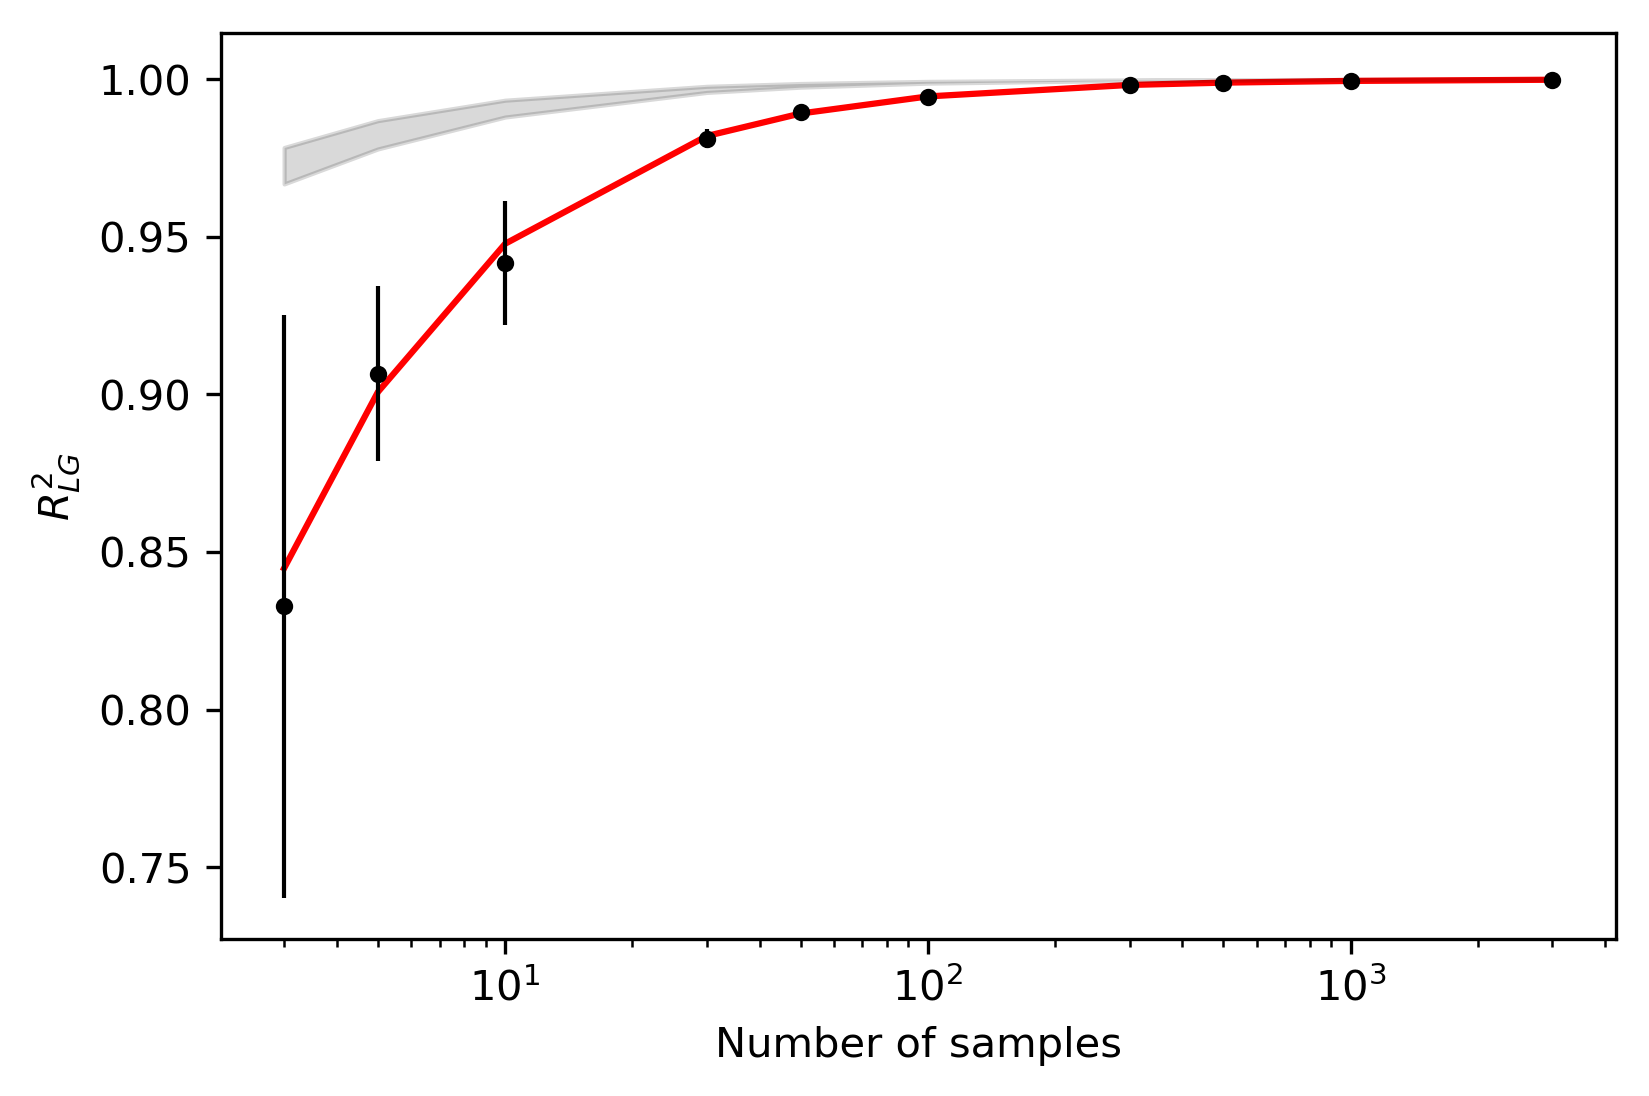

In [290]:
# fit curve in between
# awesome tool to reveal function https://mycurvefit.com/

def func(x, a, b, c, d):
    return d + (a-d)/(1+(x/c)**b)

# def func_inv(y, a, b, c):
#     return np.exp((y - c)/a)/b

# https://stackoverflow.com/questions/39434402/how-to-get-confidence-intervals-from-curve-fit
def get_fit_results(xdata,ydata,ystd,xdata2):
    # xdata2 .. plot axis
    popt, pcov = optimize.curve_fit(func,xdata,
                                    ydata,sigma=ystd,
                                   )
    perr = np.sqrt(np.diag(pcov))
    fit = popt,perr

    # plot
    plt.scatter(xdata,ydata,color='k',marker='o',s=10)
    plt.errorbar(xdata,ydata,yerr=ystd,
                 color='k',marker='o',elinewidth=1,fmt='none')
    
    plt.plot(xdata2, func(xdata2, *popt), 'r-',zorder=0)
    
    # mark some point on fitted curve
#     plt.scatter(np.exp(func_inv(points[k], *popt)),points[k],
#                 color='k',marker='x')
#     xerr=[np.exp(func_inv(points[k], *(popt + 1.96*perr/np.sqrt(10)))),
#           np.exp(func_inv(points[k], *(popt - 1.96*perr/np.sqrt(10))))]
#     plt.plot(xerr,[points[k],points[k]],
#                  color='k',linewidth=1)
#     print(np.exp(func_inv(points[k], *popt)),
#           xerr
#          )

    # plotting the confidence intervals
    bound_upper = func(xdata2, *(popt + perr)) #1.96*perr/np.sqrt(10)))
    bound_lower = func(xdata2, *(popt - perr)) #1.96*perr/np.sqrt(10)))
    plt.fill_between(xdata2, bound_lower, bound_upper,
                 color = 'black', alpha = 0.15)

    plt.xscale('log')
    plt.ylabel('$R^2_{LG}$')
    plt.xlabel('Number of samples')
    plt.show()
    return fit

xdata = df_r2.n_samples.unique()
ydata = df_r2.groupby('n_samples').r2lg.mean().values
ystd = df_r2.groupby('n_samples').r2lg.std().values

fit = get_fit_results(xdata,ydata,ystd,xdata)


In [291]:
# save intermediate results

df_r2.to_csv('dframe_r2lg_across_all.csv',index=False)


## Condition specific analysis

In [292]:
print(df[df.gene_id=='YAL005C'].experiment_title.str.contains('glutamine').sum())
print(df[df.gene_id=='YAL005C'].experiment_title.str.contains('ethanol').sum())
print(df[df.gene_id=='YAL005C'].experiment_title.str.contains('nitrogen').sum())
print(df[df.gene_id=='YAL005C'].experiment_title.str.contains('glycerol').sum())
print(df[df.gene_id=='YAL005C'].experiment_title.str.contains('NaCl').sum())

print(df[df.gene_id=='YAL005C'].experiment_title.str.contains('wt').sum())
print(df[df.gene_id=='YAL005C'].experiment_title.str.contains('wild type').sum())


19
13
289
18
22
47
62


In [293]:
df[(df.gene_id=='YAL005C')&(df[df.gene_id=='YAL005C'].experiment_title.str.contains('nitrogen'))].experiment_title

0       GSM3168583: hap1 deletion, 120min 100% nitroge...
2       GSM3168688: rox1 deletion, 5min 100% nitrogen ...
13      GSM3168781: dsc5 deletion, 0min 100% nitrogen ...
23      GSM3168871: upc2 ecm22 deletion, 10min 100% ni...
25      GSM3168630: hap3 deletion, 60min 100% nitrogen...
26      GSM3168574: hap1 deletion, 0min 100% nitrogen ...
34      GSM3168559: tpa1 ett1 deletion, 5min 100% nitr...
36      GSM3168766: dsc3 deletion, 0min 100% nitrogen ...
40      GSM3168659: hap2 hap3 hap4 hap5 deletion, 30mi...
53      GSM3168648: hap5 deletion, 120min 100% nitroge...
68      GSM3168763: dsc2 deletion, 240min 100% nitroge...
77      GSM3168566: tpa1 ett1 deletion, 60min 100% nit...
78      GSM3168623: hap3 deletion, 5min 100% nitrogen ...
80      GSM3168736: dsc1 deletion, 5min 100% nitrogen ...
81      GSM3168858: mga2 deletion, 120min 100% nitroge...
84      GSM3168778: dsc3 deletion, 180min 100% nitroge...
90      GSM3168683: mot3 deletion, 240min 100% nitroge...
114     GSM316

In [294]:
df[(df.gene_id=='YAL005C')&(df[df.gene_id=='YAL005C'].experiment_title.str.contains('NaCl'))].experiment_title

170     GSM2128938: H2A S121A mutant 15 min 0.4 M NaCl...
301     GSM1843509: 390_NaCl_rep2; Saccharomyces cerev...
328     GSM2128937: H2A S121A mutant 15 min 0.4 M NaCl...
397     GSM2375846: asy_T0(NaCl)_Spombe_rep2; Saccharo...
432     GSM2128939: H2A S121A mutant 15 min 0.4 M NaCl...
583     GSM2128934: wild type 15 min 0.4 M NaCl [Sampl...
660     GSM1843497: 389_NaCl_rep1; Saccharomyces cerev...
1081    GSM2375847: asy_T30(NaCl)_Spombe_rep2; Sacchar...
1099    GSM2592594: Spt4 AA mutant 15min 0.4M NaCl 30º...
1426    GSM2592593: Spt4 AA mutant 15min 0.4M NaCl 30º...
1496    GSM2375846: asy_T0(NaCl)_Spombe_rep2; Saccharo...
1519    GSM2128935: wild type 15 min 0.4 M NaCl [Sampl...
1528    GSM1843506: 389_NaCl_rep2; Saccharomyces cerev...
1698    GSM2592588: Spt4 WT 15min 0.4M NaCl 30ºC rep2;...
1975    GSM2592589: Spt4 WT 15min 0.4M NaCl 30ºC rep3;...
2011    GSM1843500: 390_NaCl_rep1; Saccharomyces cerev...
2026    GSM2592587: Spt4 WT 15min 0.4M NaCl 30ºC rep1;...
2323    GSM184

In [295]:
# check also across unque experiment identifiers

for col in df.columns:
    print(df[df.gene_id=='YAL005C']
 .groupby(col)
 .sample_id
 .count()
 .sort_values(ascending=False)
 .head()
)

gene_id
YAL005C    3025
Name: sample_id, dtype: int64
sample_id
SRR960714     1
SRR2831323    1
SRR2989886    1
SRR2989885    1
SRR2921836    1
Name: sample_id, dtype: int64
gene_len
2313.0    3025
Name: sample_id, dtype: int64
TPM
732.582282     2
191.592166     2
1122.484176    2
699.847250     2
386.515723     2
Name: sample_id, dtype: int64
box
8.744523     2
8.832766     2
11.613489    2
8.109667     2
8.623121     2
Name: sample_id, dtype: int64
log
7.064264    2
5.617608    2
5.755796    2
5.787806    2
6.400476    2
Name: sample_id, dtype: int64
SRR_accession
SRR960714     1
SRR2831323    1
SRR2989886    1
SRR2989885    1
SRR2921836    1
Name: sample_id, dtype: int64
QC_summary
PASS    3025
Name: sample_id, dtype: int64
SRX_accession
SRX1144293    13
SRX1144295    11
SRX1144296    11
SRX1144294    10
SRX233530      9
Name: sample_id, dtype: int64
SRS_accession
SRS1412051    44
SRS1432846    17
SRS1204171    14
SRS1030295    13
SRS918401     12
Name: sample_id, dtype: int64
SRP_

In [296]:
tmp = (df[df.gene_id=='YAL005C']
 .groupby('GSE_accession')
 .sample_id
 .count()
 .sort_values(ascending=False)
)

# first one is nitrogen exp is nitrogen exp
df_exp[(df_exp.GSE_accession==tmp.index[0])].experiment_title
df_exp[(df_exp.GSE_accession==tmp.index[2])].experiment_title
df_exp[(df_exp.GSE_accession==tmp.index[3])].experiment_title
df_exp[(df_exp.GSE_accession==tmp.index[4])].experiment_title

# indices

exp_acc = [tmp.index[i] for i in [0,1,3,4]]
print(exp_acc)
exp_summary = ['RNA-seq analysis of eight time points of a yeast strain grown in hypoxia. The time course course is repeated in different mutant strains.',
               'RNA-seq and transcriptome analysis of S. cerevisiae natural isolates having aneuploidy. Technical triplicate was performed for isogenic diploid strains having 2, 3 and 4 copies of a given chromosome (strain panels), while technical duplicate or singulate was performed on all other aneuploids.',
               'Cell-cycle transcript dynamics from two species of wild-type budding yeast growing at 30 degrees Celsius in rich media: Saccharomyces cerevisiae (BF264-15D background) and Cryptococcus neoformans var. grubii (H99F background). We compared programs of cell-cycle-regulated genes between distantly related budding yeasts.',
               'Study of the response to the osmotic shock and its effect on gene expression regulation in different strains of Saccharomyces cerevisiae (WT and Sln1/Ypd1 mutants). The cells received a sodium chloride stimulation (NaCl 0.4M), and were sampled at the time of stimulation (0 min) and in 10 and 20 minutes after the stimulation.']
exp_names = ['Nitrogen','YPD','YEPDextrose at 30c','Synthetic complete media + NaCl']


['GSE115171', 'GSE61532', 'GSE80474', 'GSE94495']


In [297]:
# perform experiment
# A. without boxcox

np.random.seed(seed)

# cond_list = ['glutamine',
#              'glycerol',
#              'nitrogen']

# nsample_list = [[3,4,5,7,10,15,
#                  df[df.gene_id=='YAL005C'].experiment_title.str.contains(cond_list[0]).sum()],
#                 [3,4,5,7,10,15,
#                  df[df.gene_id=='YAL005C'].experiment_title.str.contains(cond_list[1]).sum()],
#                 [3,4,5,7,10,15,30,50,100,
#                  df[df.gene_id=='YAL005C'].experiment_title.str.contains(cond_list[2]).sum()]]
# print(nsample_list)

nsample_list = [[3,4,5,7,10,20,30,50,100,200,
                 df[(df.GSE_accession==exp_acc[0])&(df.gene_id=='YAL005C')].shape[0]],
                [3,4,5,7,10,20,30,
                 df[(df.GSE_accession==exp_acc[1])&(df.gene_id=='YAL005C')].shape[0]],
                [3,4,5,7,10,20,30,
                 df[(df.GSE_accession==exp_acc[2])&(df.gene_id=='YAL005C')].shape[0]],
                [3,4,5,7,10,20,30,
                 df[(df.GSE_accession==exp_acc[3])&(df.gene_id=='YAL005C')].shape[0]]]
print(nsample_list)

tmp = []
for i in range(len(exp_acc)):
    print(i)
    df_slice = df[df.GSE_accession==exp_acc[i]]
    print(df_slice.sample_id.unique().shape)

    for n in nsample_list[i]:
        for ii in range(20):
            tmp.append([exp_acc[i],n,ii,r2lg(subsample_df(df_slice,n),n,'TPM')])

df_r2c = pd.DataFrame(tmp,columns=['GSE_accession','n_samples','iteration','r2lg'])
df_r2c.to_csv('dframe_r2lg_condition.csv',index=False)
df_r2c.head()
            

[[3, 4, 5, 7, 10, 20, 30, 50, 100, 200, 281], [3, 4, 5, 7, 10, 20, 30, 60], [3, 4, 5, 7, 10, 20, 30, 50], [3, 4, 5, 7, 10, 20, 30, 46]]
0
(281,)
1
(60,)
2
(50,)
3
(46,)


,GSE_accession,n_samples,iteration,r2lg
0,GSE115171,3,0,0.969310
1,GSE115171,3,1,0.970037
2,GSE115171,3,2,0.939647
3,GSE115171,3,3,0.965281
4,GSE115171,3,4,0.973599


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12]),
 <a list of 13 Text xticklabel objects>)

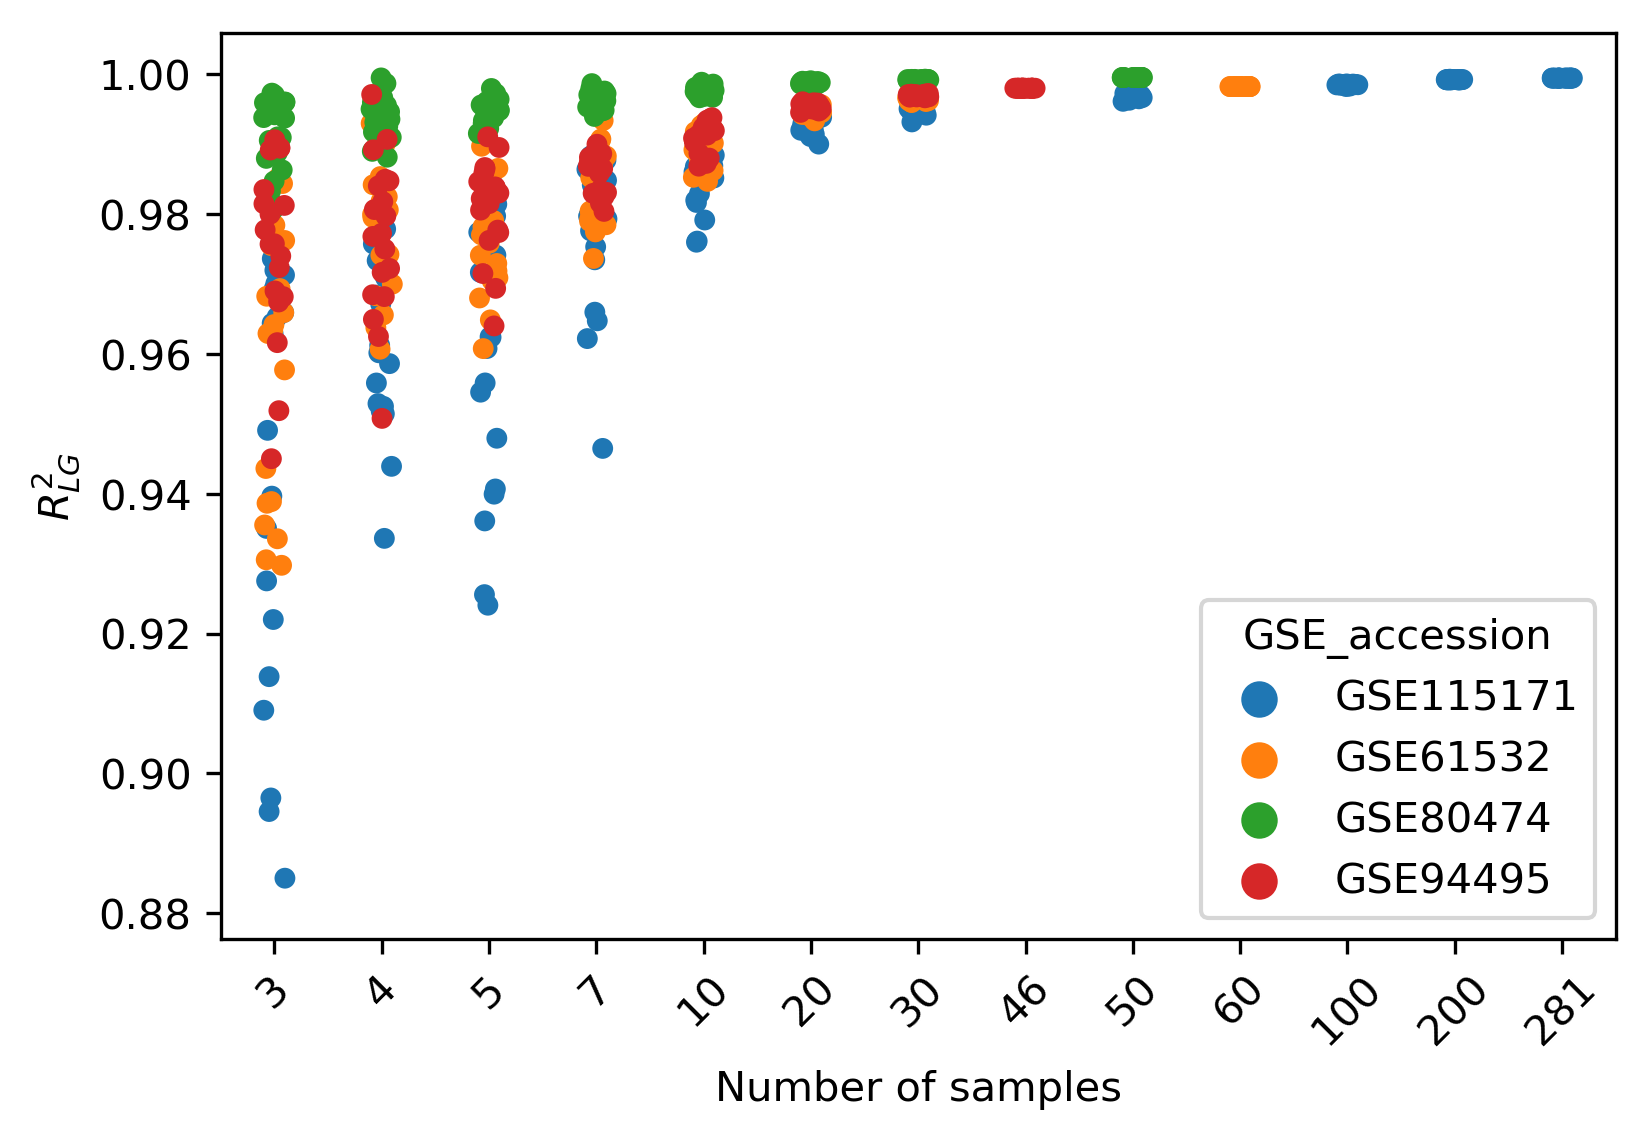

In [298]:
# plot
# https://stackoverflow.com/questions/23913151/log-log-lmplot-with-seaborn

#f, ax = plt.subplots(figsize=(2, 1.5))
#ax.set(xscale="log") # it is categorical
sns.stripplot(data=df_r2c,
             x='n_samples',y='r2lg',hue='GSE_accession')
plt.ylabel('$R^2_{LG}$')
plt.xlabel('Number of samples')
plt.xticks(rotation=45)


# Boxcox transformed TPM values

## Across all conditions

In [299]:
np.random.seed(seed)
print(df.sample_id.unique().shape)

tmp = []
for n in [3,5,10,30,50,100,300,500,1000,3000]:
    for i in range(30):
        tmp.append([n,i,r2lg(subsample_df(df,n),n,'box')])

df_r2b = pd.DataFrame(tmp,columns=['n_samples','iteration','r2lg'])
df_r2b.head()


(3025,)


,n_samples,iteration,r2lg
0,3,0,0.927860
1,3,1,0.863879
2,3,2,0.835952
3,3,3,0.870345
4,3,4,0.884652


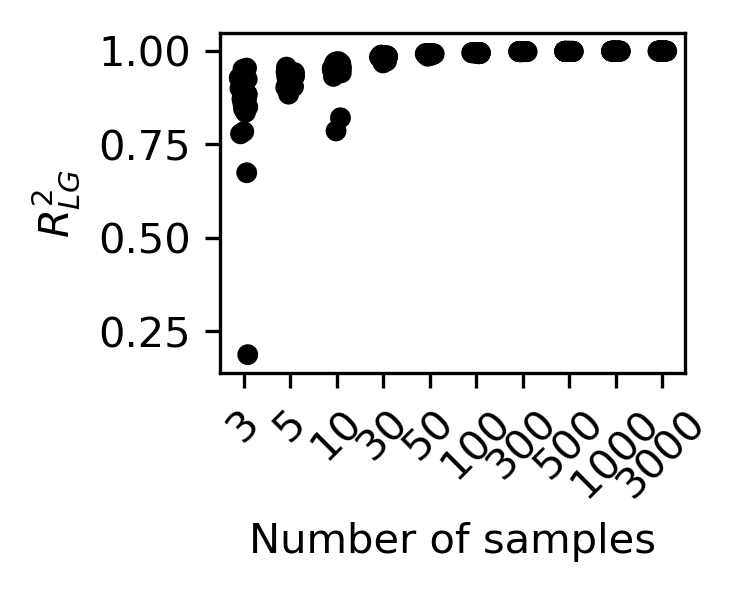

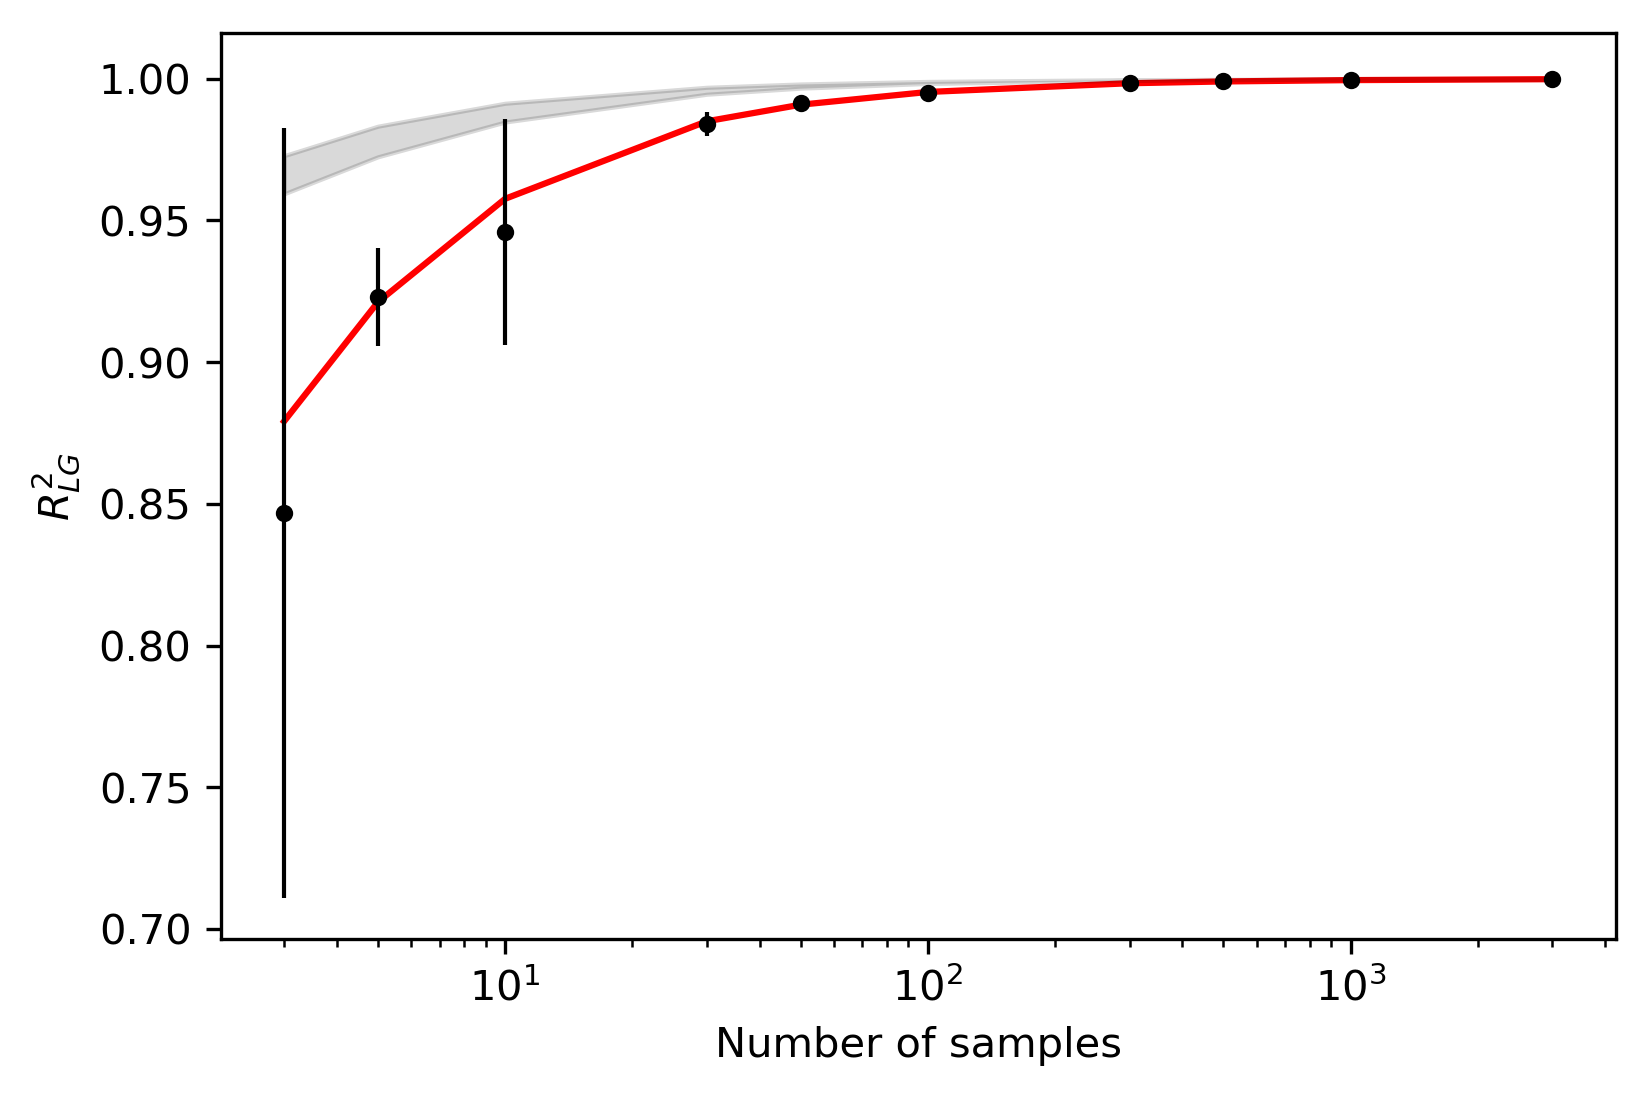

In [300]:
# plot
# https://stackoverflow.com/questions/23913151/log-log-lmplot-with-seaborn

f, ax = plt.subplots(figsize=(2, 1.5))
#df_r2b['n_samples'] = df_r2b['n_samples'].astype(int)
#ax.set(xscale="log") # it is categorical
sns.stripplot(data=df_r2b,
             x='n_samples',y='r2lg',
             color='k')
plt.ylabel('$R^2_{LG}$')
plt.xlabel('Number of samples')
plt.xticks(rotation=45)
plt.show()

# curve fit
xdata = df_r2b.n_samples.unique()
ydata = df_r2b.groupby('n_samples').r2lg.mean().values
ystd = df_r2b.groupby('n_samples').r2lg.std().values

fit = get_fit_results(xdata,ydata,ystd,xdata)


In [301]:
# save intermediate results

df_r2b.to_csv('dframe_r2lg_across_all_boxcox.csv',index=False)

## Condition specific

In [303]:
np.random.seed(seed)
tmp = []
for i in range(len(exp_acc)):
    print(i)
    df_slice = df[df.GSE_accession==exp_acc[i]]
    print(df_slice.sample_id.unique().shape)

    for n in nsample_list[i]:
        for ii in range(20):
            tmp.append([exp_acc[i],n,ii,r2lg(subsample_df(df_slice,n),n,'box')])

df_r2cb = pd.DataFrame(tmp,columns=['GSE_accession','n_samples','iteration','r2lg'])
df_r2cb.to_csv('dframe_r2lg_condition_boxcox.csv',index=False)
df_r2cb.head()

0
(281,)
1
(60,)
2
(50,)
3
(46,)


,GSE_accession,n_samples,iteration,r2lg
0,GSE115171,3,0,0.978084
1,GSE115171,3,1,0.969530
2,GSE115171,3,2,0.963264
3,GSE115171,3,3,0.957250
4,GSE115171,3,4,0.971977


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12]),
 <a list of 13 Text xticklabel objects>)

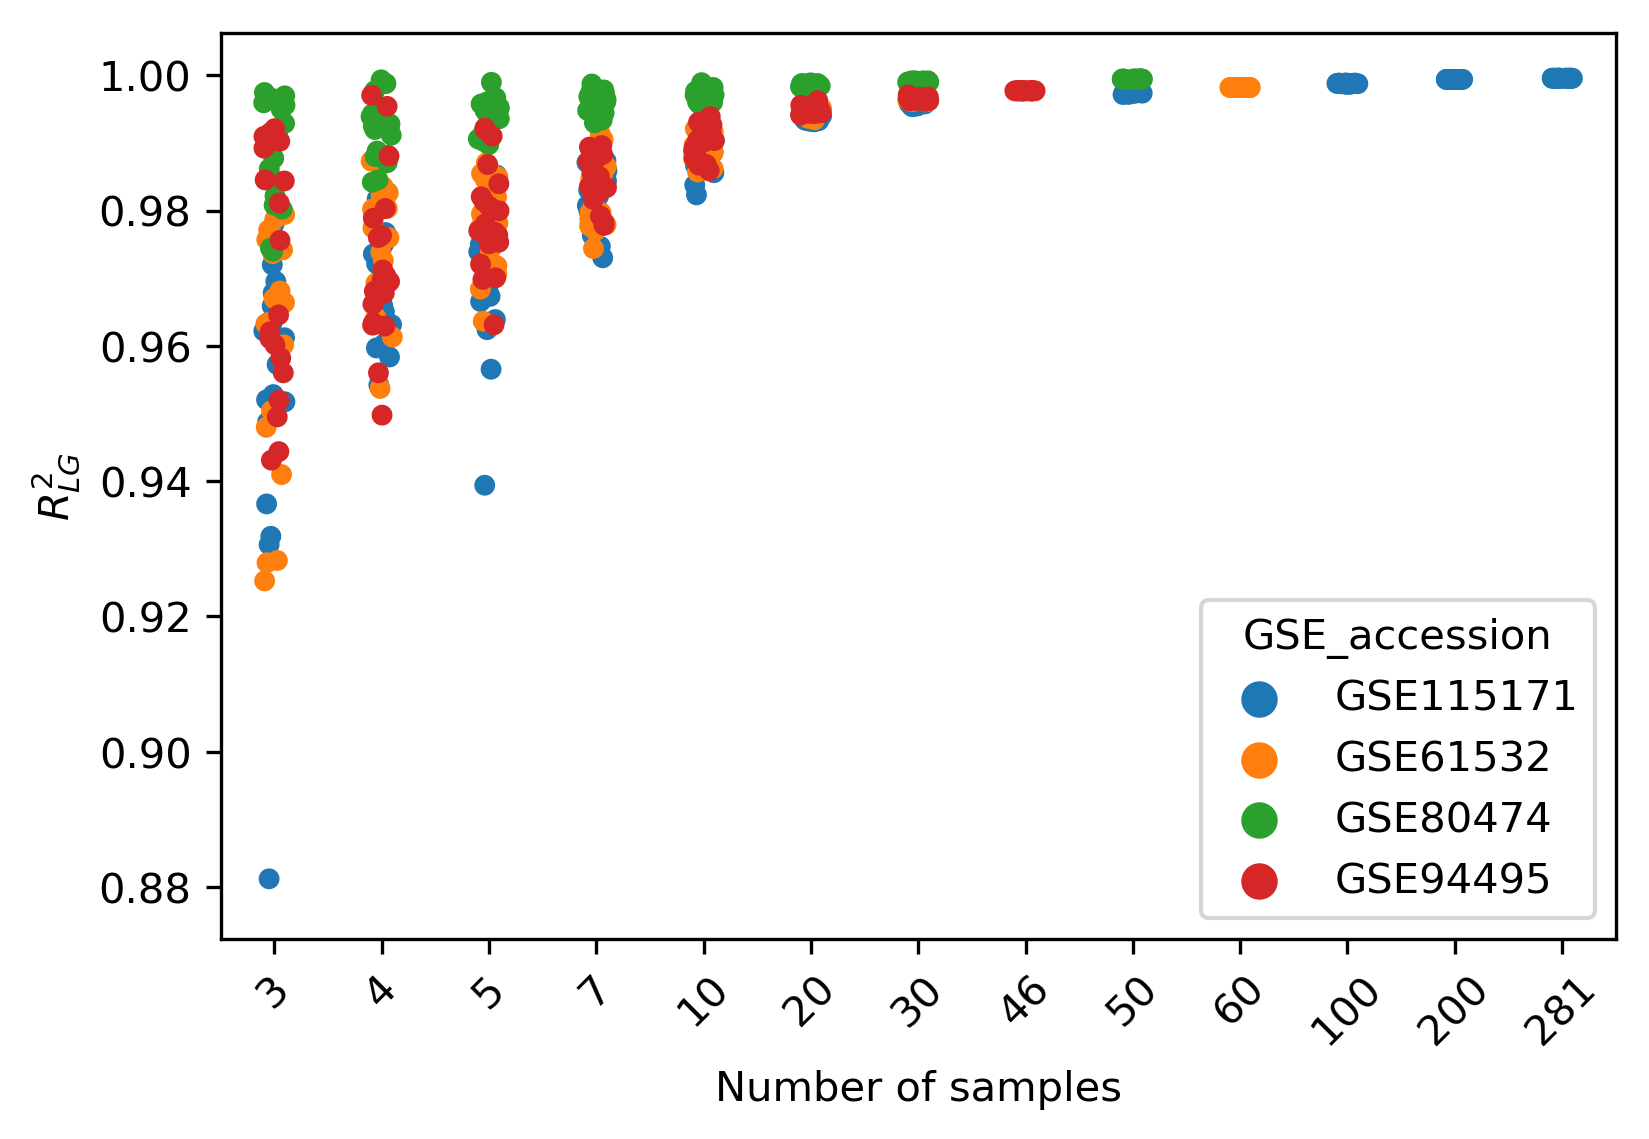

In [304]:
# plot
# https://stackoverflow.com/questions/23913151/log-log-lmplot-with-seaborn

#f, ax = plt.subplots(figsize=(2, 1.5))
#ax.set(xscale="log") # it is categorical
sns.stripplot(data=df_r2cb,
             x='n_samples',y='r2lg',hue='GSE_accession')
plt.ylabel('$R^2_{LG}$')
plt.xlabel('Number of samples')
plt.xticks(rotation=45)


# Linear modeling at different sample size

In [232]:
# argument that we have already explored feture sets
# and codon frequencies perform well enough for the
# current demonstration

# use 10 - 30 iters per 3 - all n_sample points
# use same samples as for the general analysis
# use across all condtitions for the codon case

# repurpose Azams code

## Test params

In [280]:
"""
Created on Thu Mar 14 11:46:03 2019

@author: azams

All possible variants of the datasets created by *PrepareDataSetVariants.py* 
are loaded one by one and cross validated results using **LinearRegression** 
are produced and saved as an excel sheet.
This forms the baseline results for the more sophisticated regression models.
Since, in some cases the nubmer of features grow closer to 4k, an option to 
apply PCA based dimentionality reduction is also featured. 
For this, set pcaScaling = True.
"""

import os
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_validate, KFold
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import make_pipeline
# from sklearn.decomposition import PCA

def run_lm(col):
    # # LoadDataCSV is a py file, to be present in the current working directory.
    # # LoadDataSet is a function defined in it which is used here for laoding 
    # # required data files step by step.
    # from LoadDataCSV import LoadDataSet

    # # PCA scaling is set to False by default
    pcaScaling = False
    # #%% LinearRegression applied to the entire variants of the data

    rsd = ['rsd1', 'rsd2', 'rsd3'] #r - none
    target = ['Yc', 'Yu'] #t Yc
    Ks = ['K4', 'K5', 'K5s', 'K6'] #k - none
    features = ['codon', 'stability', 'kmers', 'codon_stability', 'codon_kmers', 'codon_stability_kmers', 'stability_kmers'] 
    # only codon

    cv = KFold(n_splits=10, shuffle=True, random_state=42)

    # Log transformation to apply on the features => no diff when using boxcox
    #transformer = FunctionTransformer(np.log1p, validate=True)
    #pca = PCA(n_components=0.95, svd_solver = 'full')
    lr = LinearRegression()

    # if pcaScaling:
    #     model = make_pipeline(transformer, pca, lr)
    # else:
    #model = make_pipeline(transformer, lr)
    model = make_pipeline(lr)

    res = []
    scoring = ['neg_mean_squared_error', 'r2']

    r = rsd[0]
    t = target[0]
    k = Ks[0]
    f = features[0]

    # X, y = LoadDataSet(r,t,k,f)
    # use data generated on the fly from samples
    # X is the same, load for largest set I have (rsd3?)
    # y generate from n_samples
    np.random.seed(3131) # reset seed
    print(df.sample_id.unique().shape)

    tmp = []
    for n in [3,30,300,3000]: #[3,5,10,30,50,100,300,500,1000,3000]:
        for i in range(10):
            y = (subsample_df(df,n)
                 .groupby('gene_id')[col]
                 .median())
            # sort by gene names order same as x
            y = y.loc[gene_names]

            #print('\n'+ r + ' ' + t+ ' ' +k+ ' ' +f)
            scores = cross_validate(model, X, y, cv=cv, scoring= scoring, n_jobs=-1, return_train_score=True)
            sorted(scores.keys())
            test_mse = -1. * (scores['test_neg_mean_squared_error'].mean())
            test_r2 = scores['test_r2'].mean()
            train_mse = -1. * (scores['train_neg_mean_squared_error'].mean())
            train_r2 = scores['train_r2'].mean()
            fit_time = scores['fit_time'].mean()
            score_time = scores['score_time'].mean()
            print("train_r2: {:.2}\n test_r2: {:.2}\n train_mse: {:.2}\n test_mse: {:.2}\n fit_time: {:.2}\n score_time: {:.2}\n".format(train_r2, test_r2, train_mse, test_mse, fit_time, score_time) )
            res.append([n,i,train_r2, test_r2, train_mse, test_mse, fit_time, score_time] )

    # np.save(r+t+k,res)

    # #%% Write the results to the Excel file
    # dfres = pd.DataFrame(res)
    # dfres.columns = columns=['rsd', 'target', 'K', 'features', 'train_r2', 'test_r2', 'train_mse', 'test_mse', 'fit_time', 'score_time']
    # if pcaScaling:
    #     writer = pd.ExcelWriter(os.getcwd() + '/Results/LinearRegression_CV_results_AllData_PCA.xlsx')
    # else:
    #     writer = pd.ExcelWriter(os.getcwd() + '/Results/LinearRegression_CV_results_AllData.xlsx')

    # # write as a sheet in the excel 
    # dfres.to_excel(writer, sheet_name= 'LogTransform_LR', index=False)
    # writer.save()
    # print("Cross Validated Linear REgression results on the entire datasets have been saved in the xlsx file.")
    return res

# res = run_lm('box')
res4 = run_lm('box')



(3025,)
train_r2: 0.7
 test_r2: 0.69
 train_mse: 1.4
 test_mse: 1.4
 fit_time: 0.13
 score_time: 0.0015

train_r2: 0.7
 test_r2: 0.68
 train_mse: 1.5
 test_mse: 1.6
 fit_time: 0.13
 score_time: 0.0043

train_r2: 0.63
 test_r2: 0.61
 train_mse: 1.4
 test_mse: 1.5
 fit_time: 0.013
 score_time: 0.0013

train_r2: 0.67
 test_r2: 0.65
 train_mse: 1.4
 test_mse: 1.5
 fit_time: 0.016
 score_time: 0.003

train_r2: 0.69
 test_r2: 0.68
 train_mse: 1.2
 test_mse: 1.3
 fit_time: 0.016
 score_time: 0.0017

train_r2: 0.67
 test_r2: 0.65
 train_mse: 1.8
 test_mse: 1.9
 fit_time: 0.016
 score_time: 0.0029

train_r2: 0.67
 test_r2: 0.66
 train_mse: 1.5
 test_mse: 1.5
 fit_time: 0.016
 score_time: 0.0033

train_r2: 0.62
 test_r2: 0.6
 train_mse: 1.2
 test_mse: 1.2
 fit_time: 0.019
 score_time: 0.0041

train_r2: 0.62
 test_r2: 0.61
 train_mse: 1.5
 test_mse: 1.5
 fit_time: 0.016
 score_time: 0.0039

train_r2: 0.62
 test_r2: 0.6
 train_mse: 1.2
 test_mse: 1.3
 fit_time: 0.014
 score_time: 0.0013

train_r2:

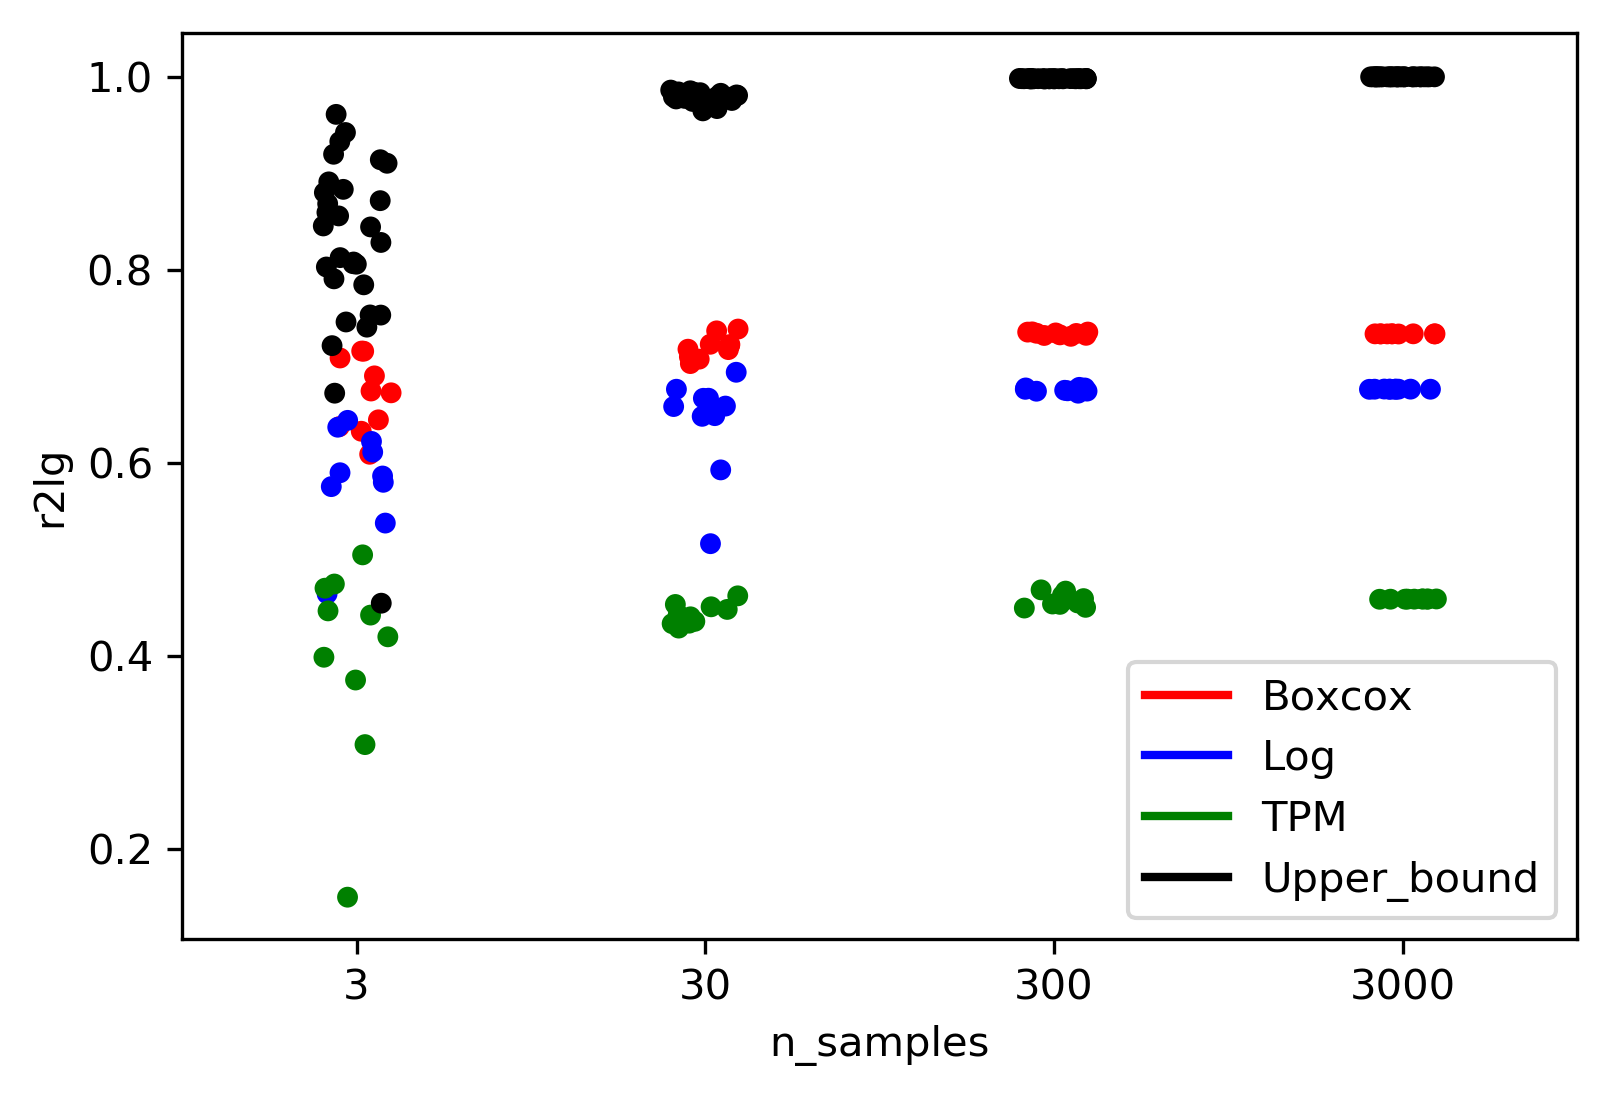

In [263]:
df_res = pd.DataFrame(res,columns=['train_r2', 'test_r2', 'train_mse', 'test_mse', 'fit_time', 'score_time'])
df_res['n_samples'] = [el for it in [np.repeat(x,10) for x in [3,30,300,3000]] for el in it]

df_res2 = pd.DataFrame(res2,columns=['train_r2', 'test_r2', 'train_mse', 'test_mse', 'fit_time', 'score_time'])
df_res2['n_samples'] = [el for it in [np.repeat(x,10) for x in [3,30,300,3000]] for el in it]

df_res3 = pd.DataFrame(res3,columns=['n_samples','iteration','train_r2', 'test_r2', 'train_mse', 'test_mse', 'fit_time', 'score_time'])

sns.stripplot(data=df_res,
             x='n_samples',y='test_r2',
             color='r')
sns.stripplot(data=df_res2,
             x='n_samples',y='test_r2',
             color='b')
sns.stripplot(data=df_res3,
             x='n_samples',y='test_r2',
             color='g')
sns.stripplot(data=df_r2[df_r2.n_samples.isin([3,30,300,3000])],
            x='n_samples',y='r2lg',
              color='k')

custom_lines = [Line2D([0], [0], color='r', lw=2),
               Line2D([0], [0], color='b', lw=2),
               Line2D([0], [0], color='g', lw=2),
               Line2D([0], [0], color='k', lw=2)]
plt.legend(custom_lines,['Boxcox','Log','TPM','Upper_bound'],loc=4)


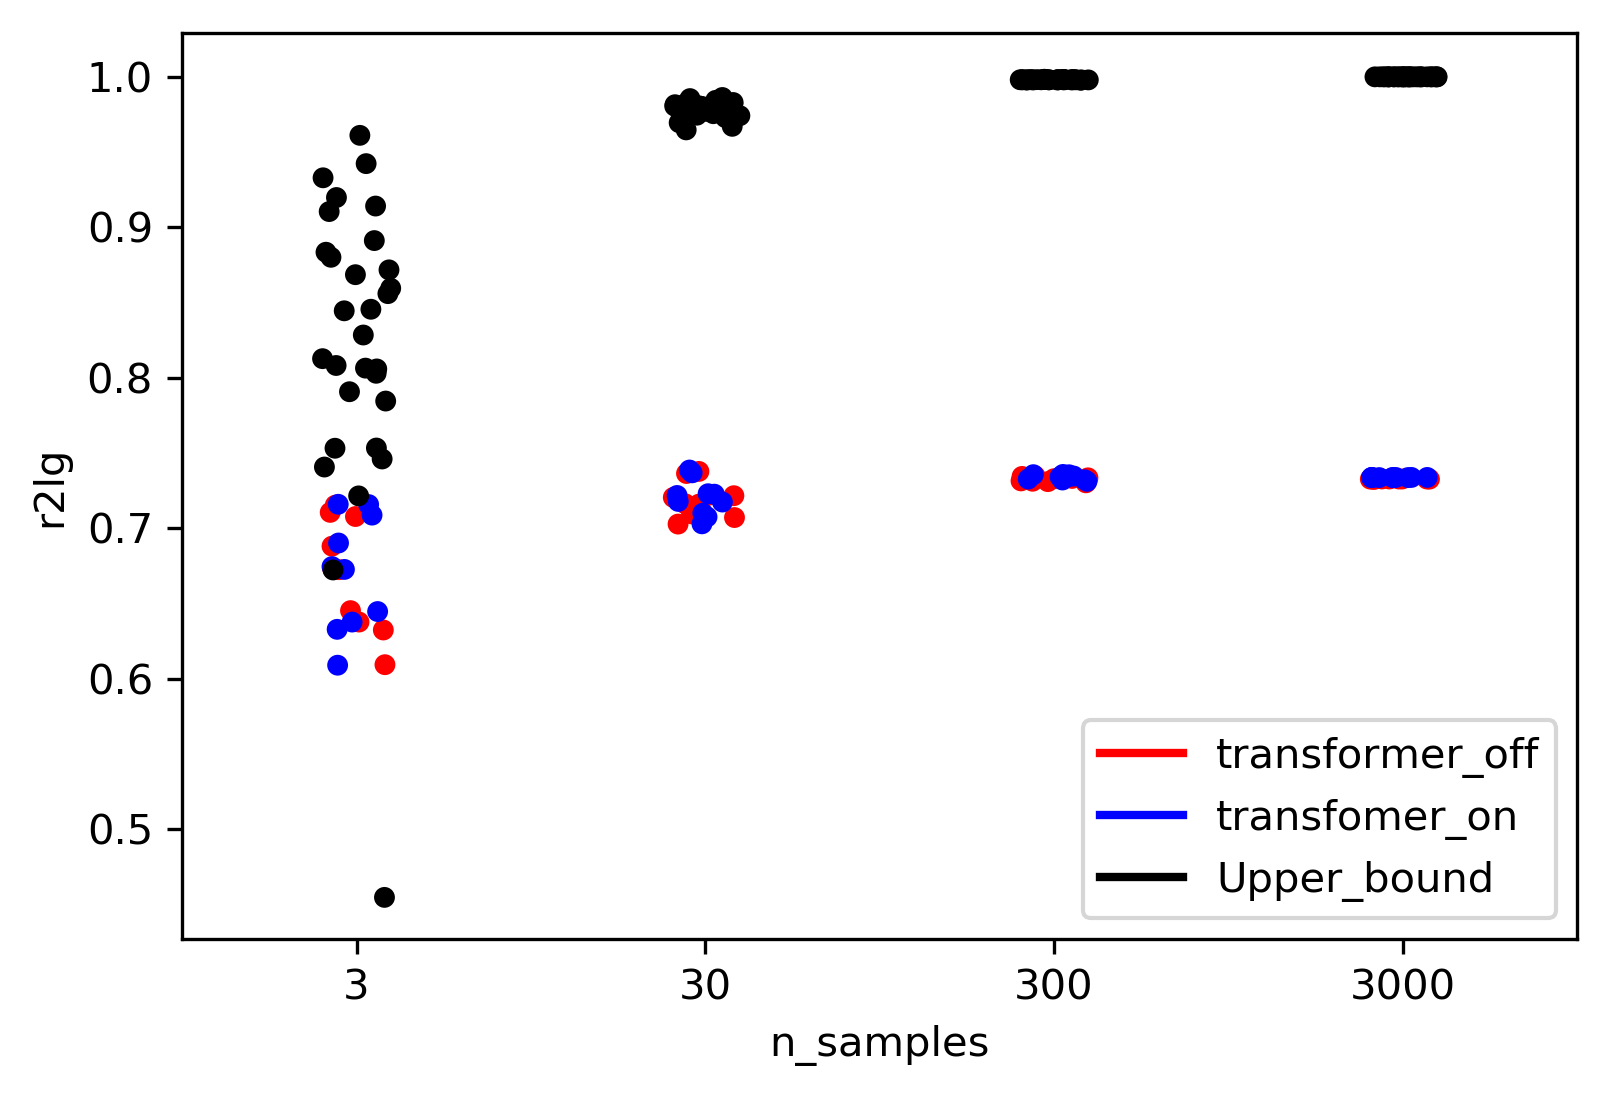

In [267]:
df_res = pd.DataFrame(res,columns=['n_samples','iteration','train_r2', 'test_r2', 'train_mse', 'test_mse', 'fit_time', 'score_time'])
df_res2 = pd.DataFrame(res2,columns=['n_samples','iteration','train_r2', 'test_r2', 'train_mse', 'test_mse', 'fit_time', 'score_time'])

sns.stripplot(data=df_res,
             x='n_samples',y='test_r2',
             color='r')
sns.stripplot(data=df_res2,
             x='n_samples',y='test_r2',
             color='b')
sns.stripplot(data=df_r2[df_r2.n_samples.isin([3,30,300,3000])],
            x='n_samples',y='r2lg',
              color='k')
custom_lines = [Line2D([0], [0], color='r', lw=2),
               Line2D([0], [0], color='b', lw=2),
               Line2D([0], [0], color='k', lw=2)]
plt.legend(custom_lines,['transformer_off','transfomer_on','Upper_bound'],loc=4)



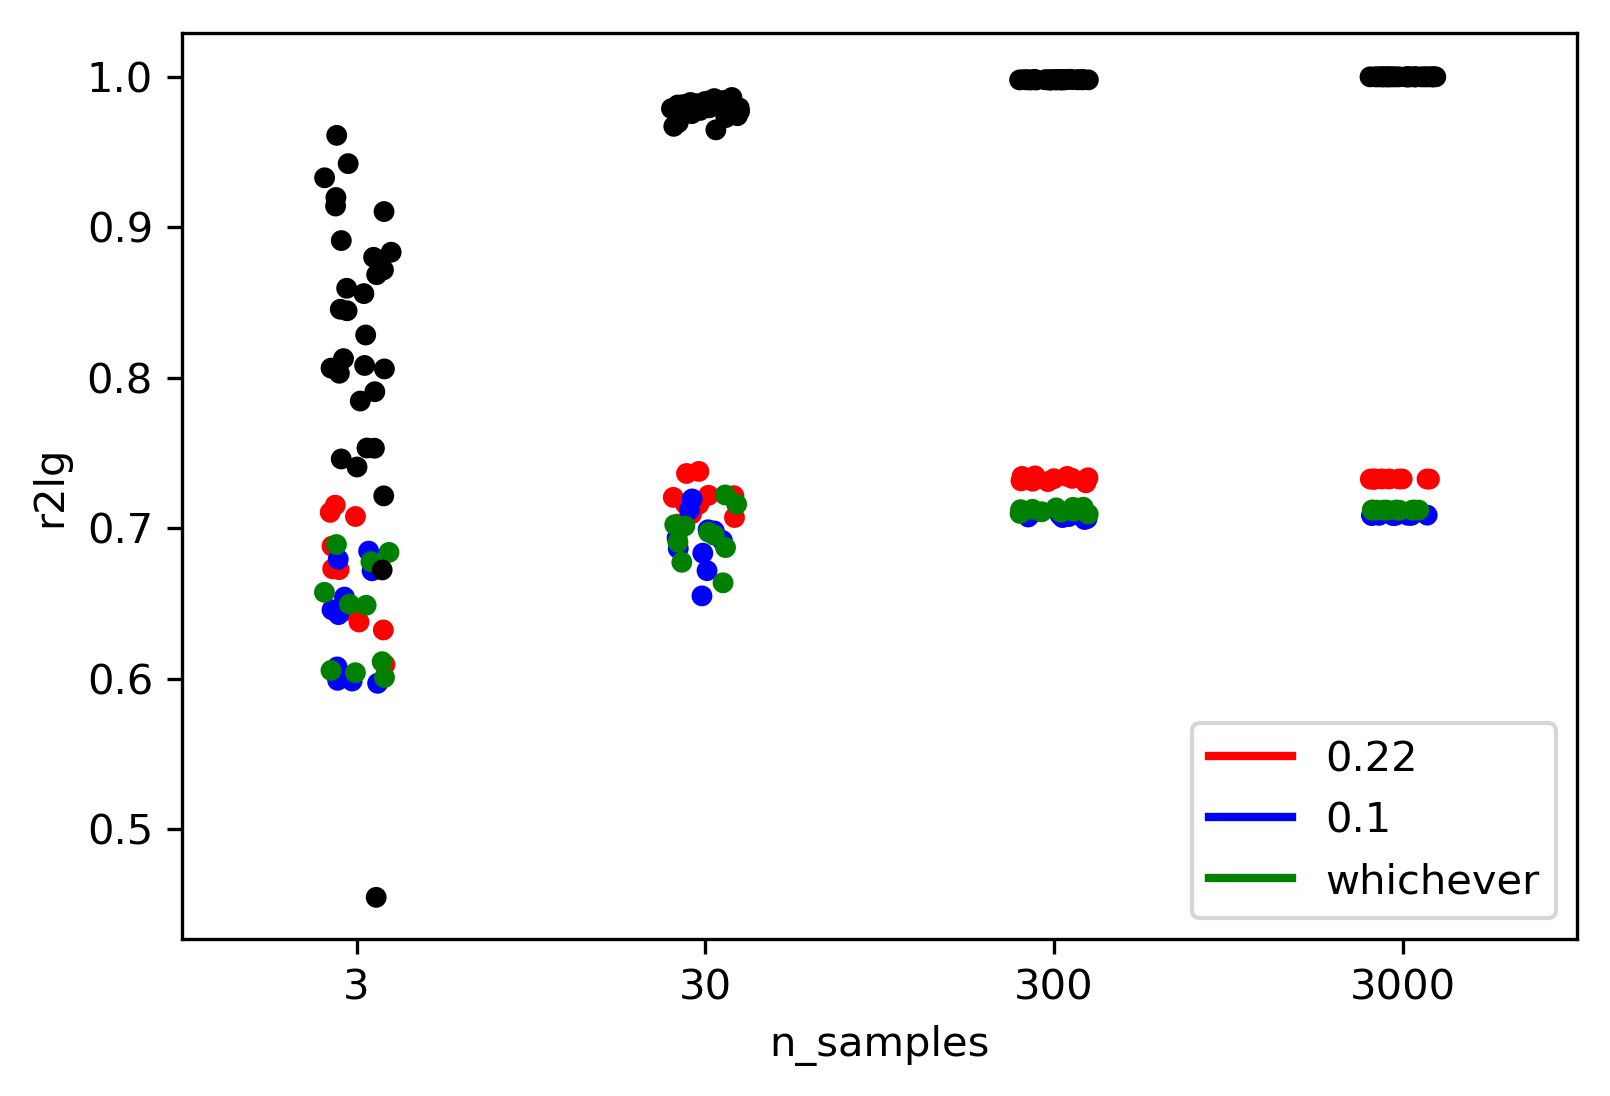

In [281]:
df_res = pd.DataFrame(res,columns=['n_samples','iteration','train_r2', 'test_r2', 'train_mse', 'test_mse', 'fit_time', 'score_time'])
df_res3 = pd.DataFrame(res3,columns=['n_samples','iteration','train_r2', 'test_r2', 'train_mse', 'test_mse', 'fit_time', 'score_time'])
df_res4 = pd.DataFrame(res4,columns=['n_samples','iteration','train_r2', 'test_r2', 'train_mse', 'test_mse', 'fit_time', 'score_time'])


sns.stripplot(data=df_res,
             x='n_samples',y='test_r2',
             color='r')
sns.stripplot(data=df_res3,
             x='n_samples',y='test_r2',
             color='b')
sns.stripplot(data=df_res4,
             x='n_samples',y='test_r2',
             color='g')
sns.stripplot(data=df_r2[df_r2.n_samples.isin([3,30,300,3000])],
            x='n_samples',y='r2lg',
              color='k')
custom_lines = [Line2D([0], [0], color='r', lw=2),
               Line2D([0], [0], color='b', lw=2),
              Line2D([0], [0], color='g', lw=2),
               Line2D([0], [0], color='k', lw=2)]
plt.legend(custom_lines,['0.22','0.1','whichever'],loc=4)

## Actual paper results

In [305]:
"""
Created on Thu Mar 14 11:46:03 2019

@author: azams

All possible variants of the datasets created by *PrepareDataSetVariants.py* 
are loaded one by one and cross validated results using **LinearRegression** 
are produced and saved as an excel sheet.
This forms the baseline results for the more sophisticated regression models.
Since, in some cases the nubmer of features grow closer to 4k, an option to 
apply PCA based dimentionality reduction is also featured. 
For this, set pcaScaling = True.
"""

import os
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_validate, KFold
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import make_pipeline
# from sklearn.decomposition import PCA

def run_lm(col):
    # # LoadDataCSV is a py file, to be present in the current working directory.
    # # LoadDataSet is a function defined in it which is used here for laoding 
    # # required data files step by step.
    # from LoadDataCSV import LoadDataSet

    # # PCA scaling is set to False by default
    pcaScaling = False
    # #%% LinearRegression applied to the entire variants of the data

    rsd = ['rsd1', 'rsd2', 'rsd3'] #r - none
    target = ['Yc', 'Yu'] #t Yc
    Ks = ['K4', 'K5', 'K5s', 'K6'] #k - none
    features = ['codon', 'stability', 'kmers', 'codon_stability', 'codon_kmers', 'codon_stability_kmers', 'stability_kmers'] 
    # only codon

    cv = KFold(n_splits=10, shuffle=True, random_state=42)

    # Log transformation to apply on the features => no diff when using boxcox
    #transformer = FunctionTransformer(np.log1p, validate=True)
    #pca = PCA(n_components=0.95, svd_solver = 'full')
    lr = LinearRegression()

    # if pcaScaling:
    #     model = make_pipeline(transformer, pca, lr)
    # else:
    #model = make_pipeline(transformer, lr)
    model = make_pipeline(lr)

    res = []
    scoring = ['neg_mean_squared_error', 'r2']

    r = rsd[0]
    t = target[0]
    k = Ks[0]
    f = features[0]

    # X, y = LoadDataSet(r,t,k,f)
    # use data generated on the fly from samples
    # X is the same, load for largest set I have (rsd3?)
    # y generate from n_samples
    np.random.seed(seed) # reset seed
    print(df.sample_id.unique().shape)

    tmp = []
    for n in [3,5,10,30,50,100,300,500,1000,3000]:
        for i in range(30):
            y = (subsample_df(df,n)
                 .groupby('gene_id')[col]
                 .median())
            # sort by gene names order same as x
            y = y.loc[gene_names]

            #print('\n'+ r + ' ' + t+ ' ' +k+ ' ' +f)
            scores = cross_validate(model, X, y, cv=cv, scoring= scoring, n_jobs=-1, return_train_score=True)
            sorted(scores.keys())
            test_mse = -1. * (scores['test_neg_mean_squared_error'].mean())
            test_r2 = scores['test_r2'].mean()
            train_mse = -1. * (scores['train_neg_mean_squared_error'].mean())
            train_r2 = scores['train_r2'].mean()
            fit_time = scores['fit_time'].mean()
            score_time = scores['score_time'].mean()
            print("train_r2: {:.2}\n test_r2: {:.2}\n train_mse: {:.2}\n test_mse: {:.2}\n fit_time: {:.2}\n score_time: {:.2}\n".format(train_r2, test_r2, train_mse, test_mse, fit_time, score_time) )
            res.append([n,i,train_r2, test_r2, train_mse, test_mse, fit_time, score_time] )

    # np.save(r+t+k,res)

    # #%% Write the results to the Excel file
    # dfres = pd.DataFrame(res)
    # dfres.columns = columns=['rsd', 'target', 'K', 'features', 'train_r2', 'test_r2', 'train_mse', 'test_mse', 'fit_time', 'score_time']
    # if pcaScaling:
    #     writer = pd.ExcelWriter(os.getcwd() + '/Results/LinearRegression_CV_results_AllData_PCA.xlsx')
    # else:
    #     writer = pd.ExcelWriter(os.getcwd() + '/Results/LinearRegression_CV_results_AllData.xlsx')

    # # write as a sheet in the excel 
    # dfres.to_excel(writer, sheet_name= 'LogTransform_LR', index=False)
    # writer.save()
    # print("Cross Validated Linear REgression results on the entire datasets have been saved in the xlsx file.")
    return res

res = run_lm('box')
df_res = pd.DataFrame(res,columns=['n_samples',
                                   'iteration',
                                   'train_r2', 
                                   'test_r2', 
                                   'train_mse', 
                                   'test_mse', 
                                   'fit_time', 
                                   'score_time'])
df_res.to_csv('dframe_lm_modeling_boxcox.csv')
df_res.head()


(3025,)
train_r2: 0.7
 test_r2: 0.69
 train_mse: 1.4
 test_mse: 1.4
 fit_time: 0.044
 score_time: 0.0014

train_r2: 0.7
 test_r2: 0.68
 train_mse: 1.5
 test_mse: 1.6
 fit_time: 0.046
 score_time: 0.0014

train_r2: 0.63
 test_r2: 0.61
 train_mse: 1.4
 test_mse: 1.5
 fit_time: 0.019
 score_time: 0.0013

train_r2: 0.67
 test_r2: 0.65
 train_mse: 1.4
 test_mse: 1.5
 fit_time: 0.018
 score_time: 0.0014

train_r2: 0.69
 test_r2: 0.68
 train_mse: 1.2
 test_mse: 1.3
 fit_time: 0.017
 score_time: 0.0014

train_r2: 0.67
 test_r2: 0.65
 train_mse: 1.8
 test_mse: 1.9
 fit_time: 0.018
 score_time: 0.0013

train_r2: 0.67
 test_r2: 0.66
 train_mse: 1.5
 test_mse: 1.5
 fit_time: 0.017
 score_time: 0.0014

train_r2: 0.62
 test_r2: 0.6
 train_mse: 1.2
 test_mse: 1.2
 fit_time: 0.017
 score_time: 0.0013

train_r2: 0.62
 test_r2: 0.61
 train_mse: 1.5
 test_mse: 1.5
 fit_time: 0.018
 score_time: 0.0014

train_r2: 0.62
 test_r2: 0.6
 train_mse: 1.2
 test_mse: 1.3
 fit_time: 0.018
 score_time: 0.0014

train_

train_r2: 0.71
 test_r2: 0.69
 train_mse: 1.1
 test_mse: 1.2
 fit_time: 0.018
 score_time: 0.0013

train_r2: 0.67
 test_r2: 0.66
 train_mse: 1.3
 test_mse: 1.3
 fit_time: 0.019
 score_time: 0.0014

train_r2: 0.71
 test_r2: 0.7
 train_mse: 1.2
 test_mse: 1.2
 fit_time: 0.018
 score_time: 0.0014

train_r2: 0.71
 test_r2: 0.7
 train_mse: 1.1
 test_mse: 1.1
 fit_time: 0.018
 score_time: 0.0013

train_r2: 0.71
 test_r2: 0.7
 train_mse: 1.2
 test_mse: 1.3
 fit_time: 0.018
 score_time: 0.0014

train_r2: 0.69
 test_r2: 0.67
 train_mse: 1.3
 test_mse: 1.4
 fit_time: 0.018
 score_time: 0.0013

train_r2: 0.68
 test_r2: 0.67
 train_mse: 1.1
 test_mse: 1.1
 fit_time: 0.018
 score_time: 0.0014

train_r2: 0.7
 test_r2: 0.69
 train_mse: 1.1
 test_mse: 1.1
 fit_time: 0.016
 score_time: 0.0012

train_r2: 0.72
 test_r2: 0.7
 train_mse: 1.0
 test_mse: 1.1
 fit_time: 0.017
 score_time: 0.0013

train_r2: 0.73
 test_r2: 0.72
 train_mse: 1.1
 test_mse: 1.1
 fit_time: 0.016
 score_time: 0.0012

train_r2: 0.7
 

train_r2: 0.71
 test_r2: 0.7
 train_mse: 1.1
 test_mse: 1.1
 fit_time: 0.018
 score_time: 0.0014

train_r2: 0.72
 test_r2: 0.7
 train_mse: 1.1
 test_mse: 1.1
 fit_time: 0.018
 score_time: 0.0014

train_r2: 0.72
 test_r2: 0.71
 train_mse: 1.1
 test_mse: 1.1
 fit_time: 0.017
 score_time: 0.0014

train_r2: 0.72
 test_r2: 0.71
 train_mse: 1.1
 test_mse: 1.1
 fit_time: 0.018
 score_time: 0.0014

train_r2: 0.72
 test_r2: 0.71
 train_mse: 1.1
 test_mse: 1.1
 fit_time: 0.017
 score_time: 0.0013

train_r2: 0.72
 test_r2: 0.71
 train_mse: 1.0
 test_mse: 1.1
 fit_time: 0.019
 score_time: 0.0014

train_r2: 0.72
 test_r2: 0.7
 train_mse: 1.0
 test_mse: 1.0
 fit_time: 0.018
 score_time: 0.0014

train_r2: 0.72
 test_r2: 0.7
 train_mse: 1.1
 test_mse: 1.1
 fit_time: 0.016
 score_time: 0.0013

train_r2: 0.73
 test_r2: 0.71
 train_mse: 1.0
 test_mse: 1.1
 fit_time: 0.018
 score_time: 0.0014

train_r2: 0.72
 test_r2: 0.71
 train_mse: 1.0
 test_mse: 1.1
 fit_time: 0.018
 score_time: 0.0013

train_r2: 0.72

train_r2: 0.72
 test_r2: 0.71
 train_mse: 1.0
 test_mse: 1.1
 fit_time: 0.017
 score_time: 0.0014

train_r2: 0.72
 test_r2: 0.71
 train_mse: 1.0
 test_mse: 1.1
 fit_time: 0.018
 score_time: 0.0014

train_r2: 0.73
 test_r2: 0.71
 train_mse: 1.0
 test_mse: 1.1
 fit_time: 0.018
 score_time: 0.0014

train_r2: 0.72
 test_r2: 0.71
 train_mse: 1.0
 test_mse: 1.1
 fit_time: 0.02
 score_time: 0.0015

train_r2: 0.72
 test_r2: 0.71
 train_mse: 1.0
 test_mse: 1.1
 fit_time: 0.018
 score_time: 0.0014

train_r2: 0.72
 test_r2: 0.71
 train_mse: 1.0
 test_mse: 1.1
 fit_time: 0.019
 score_time: 0.0015

train_r2: 0.72
 test_r2: 0.71
 train_mse: 1.0
 test_mse: 1.1
 fit_time: 0.018
 score_time: 0.0015

train_r2: 0.72
 test_r2: 0.71
 train_mse: 1.0
 test_mse: 1.1
 fit_time: 0.018
 score_time: 0.0014

train_r2: 0.72
 test_r2: 0.71
 train_mse: 1.0
 test_mse: 1.1
 fit_time: 0.017
 score_time: 0.0013

train_r2: 0.72
 test_r2: 0.71
 train_mse: 1.0
 test_mse: 1.1
 fit_time: 0.019
 score_time: 0.0014

train_r2: 0

,n_samples,iteration,train_r2,test_r2,train_mse,test_mse,fit_time,score_time
0,3,0,0.704095,0.689014,1.374654,1.440171,0.044203,0.001415
1,3,1,0.697114,0.683804,1.505109,1.565134,0.045845,0.001431
2,3,2,0.629267,0.611187,1.435367,1.498871,0.018996,0.001285
3,3,3,0.666465,0.649445,1.392662,1.458124,0.017732,0.001372
4,3,4,0.689640,0.677612,1.239153,1.290340,0.016792,0.001370


In [6]:
# load 
# original non-transformed y r2lg 
df_r2 = pd.read_csv('dframe_r2lg_across_all.csv')
df_r2.head()

# boxcox transfomred y linear models
df_res = pd.read_csv('dframe_lm_modeling_boxcox.csv')
df_res.head()


,Unnamed: 0,n_samples,iteration,train_r2,test_r2,train_mse,test_mse,fit_time,score_time
0,0,3,0,0.704095,0.689014,1.374654,1.440171,0.044203,0.001415
1,1,3,1,0.697114,0.683804,1.505109,1.565134,0.045845,0.001431
2,2,3,2,0.629267,0.611187,1.435367,1.498871,0.018996,0.001285
3,3,3,3,0.666465,0.649445,1.392662,1.458124,0.017732,0.001372
4,4,3,4,0.689640,0.677612,1.239153,1.290340,0.016792,0.001370


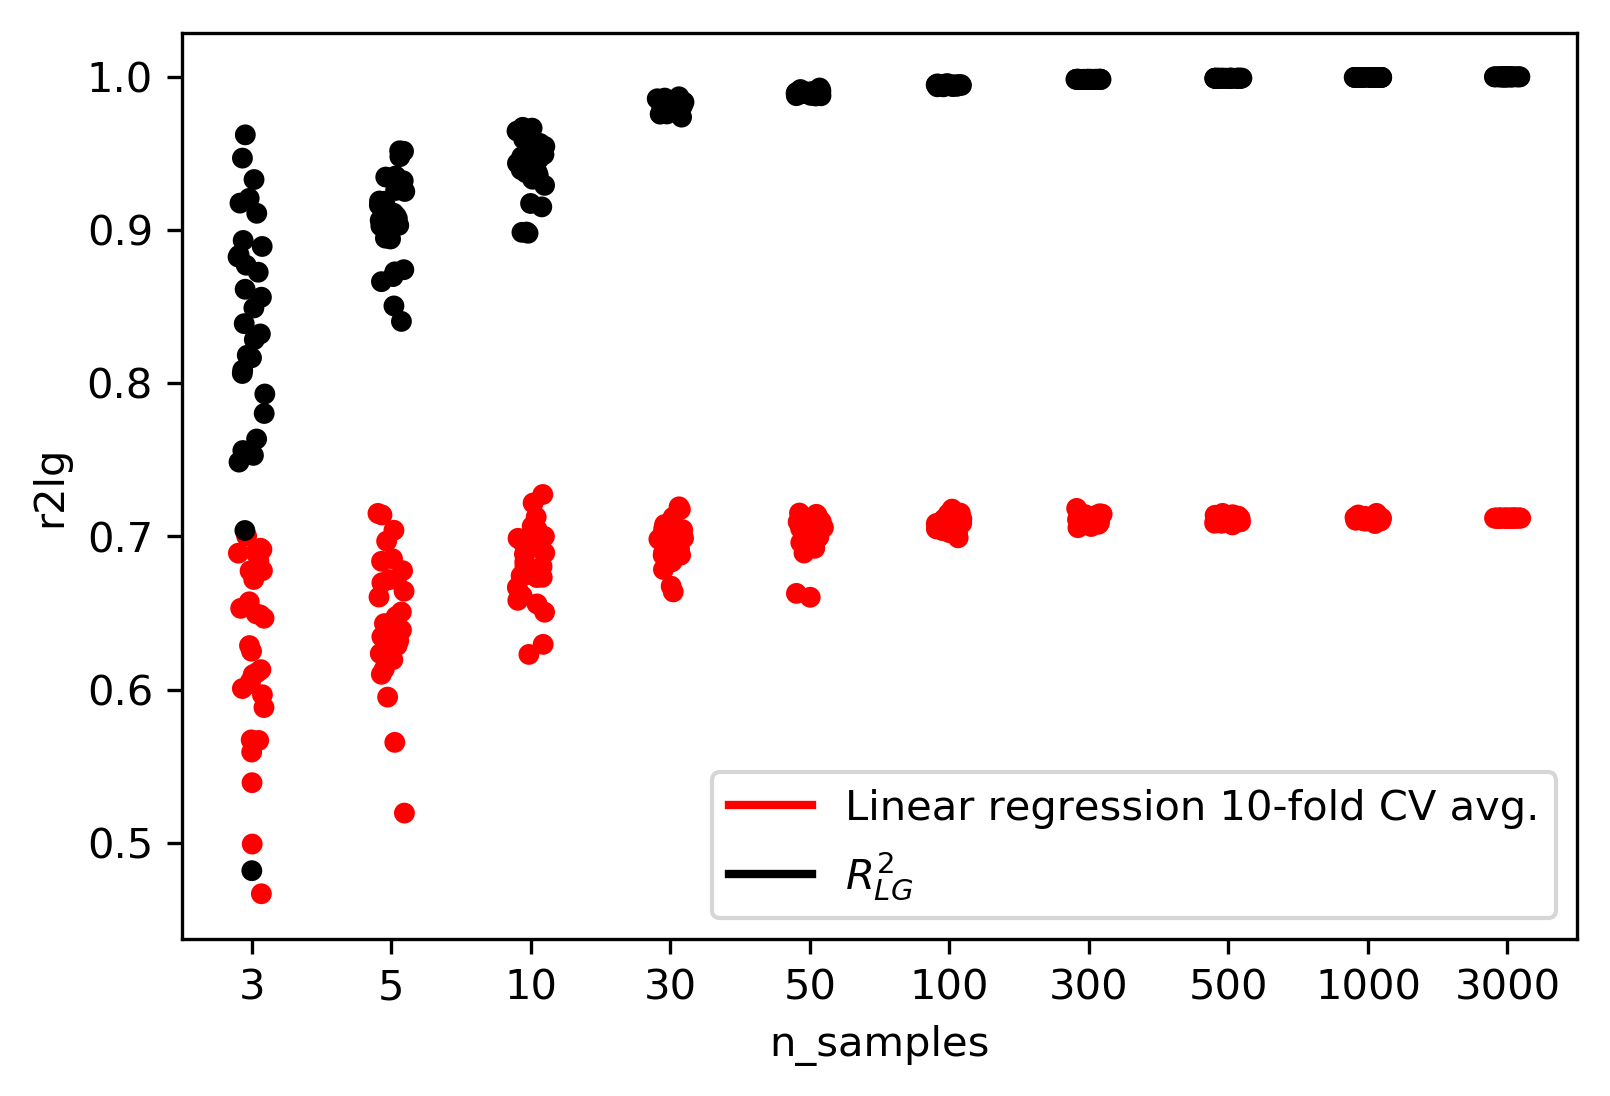

In [306]:
# plot

sns.stripplot(data=df_res,
             x='n_samples',y='test_r2',
             color='r')
sns.stripplot(data=df_r2,
            x='n_samples',y='r2lg',
              color='k')

custom_lines = [Line2D([0], [0], color='r', lw=2),
               Line2D([0], [0], color='k', lw=2)]
plt.legend(custom_lines,['Linear regression 10-fold CV avg.','$R^2_{LG}$'],loc=4)


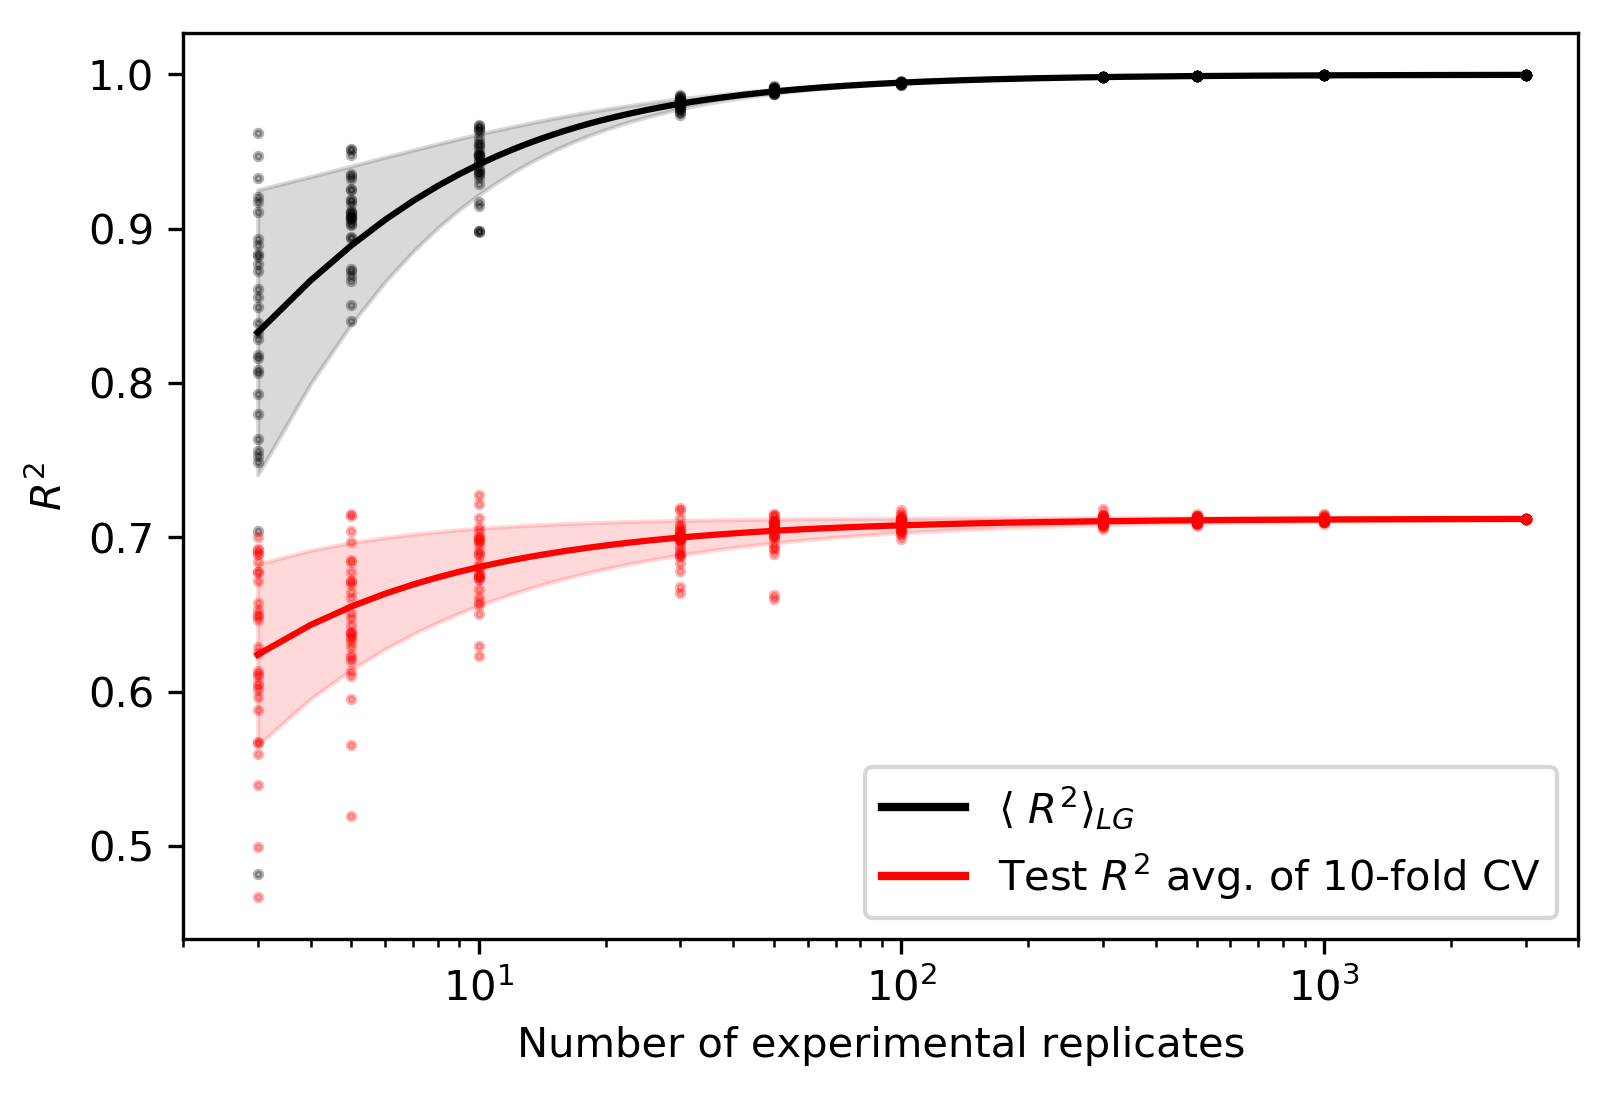

In [27]:
# fit curves plot
# overlay over stripplot or below at points
pts = [3,10,30,100,300,1000,3000]

def func(x, a, b, c, d):
    return d + (a-d)/(1+(x/c)**b)

def get_fit_results(xdata,ydata,ystd):
    popt, pcov = optimize.curve_fit(func,xdata,
                                    ydata,#sigma=ystd,
                                    maxfev=10000
                                   )
    perr = np.sqrt(np.diag(pcov))
    fit = popt,perr
    return fit

# make combined plot 
xdata = df_r2[df_r2.n_samples.isin(pts)].n_samples.unique()
ydata = df_r2[df_r2.n_samples.isin(pts)].groupby('n_samples').r2lg.mean().values
ystd = df_r2[df_r2.n_samples.isin(pts)].groupby('n_samples').r2lg.std().values
fit_r2 = get_fit_results(xdata,ydata,ystd)

# plt.scatter(xdata,ydata,color='k',marker='o',s=10)
# plt.errorbar(xdata,ydata,yerr=ystd,
#              color='k',marker='o',elinewidth=1,fmt='none')

xdata2 = list(range(3,3001,1))
plt.plot(xdata2, func(xdata2, *fit_r2[0]), 'k-',zorder=0)

# plotting the confidence intervals / std
fit_r2_upper = get_fit_results(xdata,ydata+ystd,ystd)
bound_upper = func(xdata2, *(fit_r2_upper[0]))
fit_r2_lower = get_fit_results(xdata,ydata-ystd,ystd)
bound_lower = func(xdata2, *(fit_r2_lower[0]))
plt.fill_between(xdata2, bound_lower, bound_upper,
             color = 'k', alpha = 0.15)

plt.scatter(df_r2.n_samples,df_r2.r2lg,
            s=3,color='k',alpha=0.3,zorder=0)

xdata = df_res[df_res.n_samples.isin(pts)].n_samples.unique()
ydata = df_res[df_res.n_samples.isin(pts)].groupby('n_samples').test_r2.mean().values
ystd = df_res[df_res.n_samples.isin(pts)].groupby('n_samples').test_r2.std().values
fit_res = get_fit_results(xdata,ydata,ystd)

plt.plot(xdata2, func(xdata2, *fit_res[0]), 'r-',zorder=0)

# plotting the confidence intervals / std
fit_r2_upper = get_fit_results(xdata,ydata+ystd,ystd)
bound_upper = func(xdata2, *(fit_r2_upper[0]))
fit_r2_lower = get_fit_results(xdata,ydata-ystd,ystd)
bound_lower = func(xdata2, *(fit_r2_lower[0]))
plt.fill_between(xdata2, bound_lower, bound_upper,
             color = 'r', alpha = 0.15)

plt.scatter(df_res.n_samples,df_res.test_r2,
            s=3,color='r',alpha=0.3,zorder=0)

plt.xlim(2,4000)
plt.xscale('log')
plt.ylabel('$R^2$')
plt.xlabel('Number of experimental replicates')

custom_lines = [Line2D([0], [0], color='k', lw=2),
               Line2D([0], [0], color='r', lw=2)]
#label=r’$\langle$ $R^2$$\rangle_{LG}$'
plt.legend(custom_lines,[r'$\langle$ $R^2$$\rangle_{LG}$','Test $R^2$ avg. of 10-fold CV'],loc=4)

plt.show()


In [20]:
# values used in text
tmp = (df_r2
       .groupby('n_samples')
       .r2lg
       .mean()
       .reset_index()
       .rename(columns={'r2lg':'r2lg_mean'})
      )
tmp['r2lg_std'] = (df_r2
       .groupby('n_samples')
       .r2lg
       .std()
       .values
      )
tmp['testr2_mean'] = (df_res
       .groupby('n_samples')
       .test_r2
       .mean()
       .values
      )
tmp['testr2_std'] = (df_res
       .groupby('n_samples')
       .test_r2
       .std()
       .values
      )
tmp


,n_samples,r2lg_mean,r2lg_std,testr2_mean,testr2_std
0,3,0.832724,9.243485e-02,0.623630,0.058951
1,5,0.906575,2.768486e-02,0.645648,0.042305
2,10,0.941564,1.966926e-02,0.682208,0.024147
3,30,0.981154,3.141092e-03,0.696927,0.012449
4,50,0.989579,1.324936e-03,0.701996,0.012739
5,100,0.994400,5.277281e-04,0.708948,0.004187
6,300,0.998177,8.455034e-05,0.710713,0.002762
7,500,0.998901,4.657229e-05,0.711249,0.001971
8,1000,0.999448,1.365996e-05,0.711446,0.001416
9,3000,0.999815,3.633723e-07,0.711900,0.000066
